## Novel Molecule Generation using Bidirectional-Recurrent Neural Networks with Attention Applied to Simplified Molecular Input Line Entry Sysem (SMILES)

## Generate Molecules

author: anthony j. vasquez
email: vanthony715@gmail.com / avasque1@jh.edu

In [1]:
import time
from datetime import datetime
t0 = time.time()

import sys
sys.path.append('./data/')

import gc
gc.collect()

import os
##had a hard time with this setting on windows os using spyder and jypyter
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import warnings
warnings.filterwarnings("ignore")

import platform
print("Operating System: ", platform.system())
print("Machine Type:: ", platform.machine())

import multiprocessing as mp
max_processors = mp.cpu_count()
print('Processor Count: ', max_processors, '\n')

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split

from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

from net import *
from utils import *
from custom_dataset import *

if torch.cuda.is_available():
    torch.cuda.empty_cache() #empty cache
    print('CUDA Version')
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')
    print('\n')

##hardware params
# DEVICE = torch.device('cpu') #DEBUG
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device: \n', DEVICE)

Operating System:  Linux
Machine Type::  x86_64
Processor Count:  24 

CUDA Version
CUDNN Version: 90100
Number of CUDA Devices: 2
Active CUDA Device: 0
Available devices: 2, Name: NVIDIA RTX A4000
Current CUDA device: 0


Using Device: 
 cuda


#### Hyperparameters

In [2]:
##OS
LINUX = True #windows isn't nice with parallel processes
MULTI_GPU = True #trains using multiple gpus
N_PROCESSORS = max_processors - 2 #leave 2 processors free 

##data
HOLDOUT_PERC = 0.85 #percentage to holdout 
TRAIN_BS = 512 #train batch size
PREFETCH_FACTOR = 4 #effectively reduces gpu load time 
NUM_WORKERS = 8 #number of jobs for generation tasks

##inference
N_SAMPLES = 1000 #num samples to generate
MAX_LENGTH = 10 #len of samples to generate
EMBEDDING_DIM = 32 #how large of a vector to represent input data
HIDDEN_DIM = 64 #learned embeddings
DROPOUT_PROB = 0.25 #drop out for all layers except fully connected
BIDIRECTIONAL = True #makes gru layer bidirectional
N_HEADS = 4 #number of heads for attention, scaled dot-product for head's respective section of sequence

##visualization params
SIGMA = 2 #loss smoothing for lineplot
PRINT_LOSS_EVERY = 2 #how many epochs to output loss

##logging
RESULTS_PATH = '../results/example_run/'

In [3]:
WRITEPATH = RESULTS_PATH + 'infererence/'
make_dir(WRITEPATH)

Created Folder at:  ./results/example_run/infererence/


#### Open SMILES Data

In [4]:
%%time

### Import the data
data_file = pd.read_csv('../data/Zinc_all_smiles_data.txt', header = None)
data_file.columns = ['smiles']
smilesList = data_file['smiles'].tolist()

# ##split dset
# train_smiles, holdout_smiles, _, _ = train_test_split(smilesList, smilesList, test_size=HOLDOUT_PERC, random_state=42)
# print('Len all smiles: ', len(smilesList))
# print('Len train smiles: ', len(train_smiles))
# print('Len holdout smiles: ', len(holdout_smiles))

print('\n')



CPU times: user 156 ms, sys: 390 µs, total: 156 ms
Wall time: 156 ms


In [5]:
%%time

# Example usage:
vocab = build_vocabulary(smilesList)
max_length = max(len(tokenize_smiles(smiles)) for smiles in smilesList)

print('Data Summary: ')
print('smilesList Len: ', len(smilesList))
print('vocab len: ', len(vocab))
print('max_length: ', max_len)
print('\n')

Data Summary: 
smilesList Len:  249456
vocab len:  254593
max_length:  10


CPU times: user 382 ms, sys: 18.1 ms, total: 400 ms
Wall time: 399 ms


### Instantiate GAN and Discriminator Networks

In [6]:
%%time

##init Generator networks
n_gen = Generator(vocab_size=len(vocab) + 1, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, max_length=MAX_LENGTH, 
                  num_heads=N_HEADS, dropout_prob=DROPOUT_PROB, bidirectional=BIDIRECTIONAL).to(DEVICE)

print('\nTotal generator param cnt: ', count_parameters(n_gen))
print('Trainable generator param cnt: ', count_trainable_parameters(n_gen))

if MULTI_GPU:
    ##for multi-gpu
    n_gen = nn.DataParallel(n_gen)

n_gen.load_state_dict(torch.load(RESULTS_PATH + 'gnet.pt'))

print('\n')


Total generator param cnt:  41093314
Trainable generator param cnt:  41093314


CPU times: user 1.19 s, sys: 340 ms, total: 1.53 s
Wall time: 4.64 s


In [7]:
n_gen

DataParallel(
  (module): Generator(
    (embedding): Embedding(254594, 32)
    (gru): GRU(32, 64, batch_first=True, dropout=0.25, bidirectional=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (fc): Linear(in_features=128, out_features=254594, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)

### Generate Molecules Using Trained GAN Generator 

In [8]:
%%time

gen_smiles = generate_smiles(n_gen, vocab, num_samples=N_SAMPLES, max_length=MAX_LENGTH, device=DEVICE)

print('\n')



CPU times: user 21.5 s, sys: 1.19 s, total: 22.7 s
Wall time: 27.7 s


### Check Validity

In [9]:
%%capture

valid_smiles, invalid_smiles = check_smiles_validity(gen_smiles)

### Check Novelty

In [10]:
%%time

known_can_smiles = process_smiles_in_parallel(smiles_list=smilesList, function_object=canonicalize_smiles, n_processors=N_PROCESSORS)
print('\nLen known canonical smiles: ', len(known_can_smiles))

##iterate over unique valid smiles generations, then compare with known smiles
print('\nChecking Novelty of Unique GAN Generated Samples')
novel_smiles = [] 
for smiles in list(set(valid_smiles)):
    can_smiles = canonicalize_smiles(smiles)
    if is_novel(can_smiles, known_can_smiles):
        novel_smiles.append(smiles)

print('\nNovel Cnt: ', len(novel_smiles))
print('\n----------------------Novel Smiles----------------------')
for i, smiles in enumerate(novel_smiles):
    print(f'\n{i}. {smiles}')
print('\n')


Len known canonical smiles:  249456

Checking Novelty of Unique GAN Generated Samples

Novel Cnt:  18

----------------------Novel Smiles----------------------

0. CC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1C

1. COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1

2. COc1cccc(NC(=O)C(=O)NCC2CCN(c3nc4ccccc4o3)CC2)c1COc1cccc(NC(=O)C(=O)NCC2CCN(c3nc4ccccc4o3)CC2)c1COc1cccc(NC(=O)C(=O)NCC2CCN(c3nc4ccccc4o3)CC2)c1COc1cccc(NC(=O)C(=O)NCC2CCN(c3nc4ccccc4o3)CC2)c1COc1cccc(NC(=O)C(=O)NCC2CCN(c3nc4ccccc4o3)CC2)c1COc1cccc(NC(=O)C(=O)NCC2CCN(c3nc4ccccc4o3)CC2)c1COc1cccc(NC(=O)C(

### Check Solubility

In [11]:
%%time

aq_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, function_object=estimate_solubility, n_processors=N_PROCESSORS)
print('\nKnown Smiles Solubility Score (logS) Stats')
print('Min: ', np.round(np.min(aq_scores_smilesList), 3))
print('Max: ', np.round(np.max(aq_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(aq_scores_smilesList), 3))

GAN_aq_scores_smilesList = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), function_object=estimate_solubility, n_processors=N_PROCESSORS)
print('\nGAN Generated Smiles Solubility Score (logS) Stats')
print('Min: ', np.round(np.min(GAN_aq_scores_smilesList), 3))
print('Max: ', np.round(np.max(GAN_aq_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(GAN_aq_scores_smilesList), 3))

##iterate over unique valid smiles generations, then compare with known smiles
print('\nGAN Generated Smiles Solubility Score (logS)')
for smiles in list(set(valid_smiles)):
    logS = estimate_solubility(smiles)
    print('Solubility Score: ', logS)
print('\n')


Known Smiles Solubility Score (logS) Stats
Min:  -12.329
Max:  8.422
Mean:  -3.172

GAN Generated Smiles Solubility Score (logS) Stats
Min:  -73.72
Max:  8.726
Mean:  -35.571

GAN Generated Smiles Solubility Score (logS)
Solubility Score:  -24.433
Solubility Score:  -22.943
Solubility Score:  -27.696
Solubility Score:  -43.042
Solubility Score:  -44.318
Solubility Score:  -73.72
Solubility Score:  -48.89
Solubility Score:  -32.482
Solubility Score:  8.726
Solubility Score:  -8.353
Solubility Score:  -47.032
Solubility Score:  3.185
Solubility Score:  -28.662
Solubility Score:  -60.206
Solubility Score:  -36.814
Solubility Score:  -56.592
Solubility Score:  -56.218
Solubility Score:  -40.791


CPU times: user 400 ms, sys: 1.29 s, total: 1.69 s
Wall time: 11 s


### Calculate Druglikeliness

In [12]:
%%time

qed_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, function_object=calculate_qed, n_processors=N_PROCESSORS)
print('\nKnown Smiles Druglikeliness Score (QED) Stats')
print('Min: ', np.round(np.min(qed_scores_smilesList), 3))
print('Max: ', np.round(np.max(qed_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(qed_scores_smilesList), 3))
print('Std: ', np.round(np.std(qed_scores_smilesList), 3))

GAN_qed_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, function_object=calculate_qed, n_processors=N_PROCESSORS)
print('\nGAN Generated Smiles Druglikeliness Score (QED) Stats')
print('Min: ', np.round(np.min(GAN_qed_scores_smilesList), 3))
print('Max: ', np.round(np.max(GAN_qed_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(GAN_qed_scores_smilesList), 3))
print('Std: ', np.round(np.std(GAN_qed_scores_smilesList), 3))

print('\nGAN Generated Smiles Druglikeliness Score (QED)')
for i, smiles in enumerate(list(set(valid_smiles))):
    qed_score = calculate_qed(smiles)
    print(f"{i}. QED score: {qed_score}")
print('\n')


Known Smiles Druglikeliness Score (QED) Stats
Min:  0.117
Max:  0.948
Mean:  0.732
Std:  0.139

GAN Generated Smiles Druglikeliness Score (QED) Stats
Min:  0.117
Max:  0.948
Mean:  0.732
Std:  0.139

GAN Generated Smiles Druglikeliness Score (QED)
0. QED score: 0.025
1. QED score: 0.032
2. QED score: 0.016
3. QED score: 0.017
4. QED score: 0.012
5. QED score: 0.013
6. QED score: 0.032
7. QED score: 0.012
8. QED score: 0.037
9. QED score: 0.025
10. QED score: 0.016
11. QED score: 0.205
12. QED score: 0.016
13. QED score: 0.017
14. QED score: 0.016
15. QED score: 0.015
16. QED score: 0.012
17. QED score: 0.017


CPU times: user 735 ms, sys: 1.41 s, total: 2.15 s
Wall time: 49.8 s


### Calculate Synthesizeability

In [13]:
%%time

sa_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, function_object=estimate_synthesizeability, n_processors=N_PROCESSORS)
print('\nKnown Smiles Synthesizeability Score (SA) Stats')
print('Min: ', np.round(np.min(sa_scores_smilesList), 3))
print('Max: ', np.round(np.max(sa_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(sa_scores_smilesList), 3))
print('Std: ', np.round(np.std(sa_scores_smilesList), 3))

GAN_sa_scores_smilesList = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), function_object=estimate_synthesizeability, n_processors=N_PROCESSORS)
print('\nGAN Generated Synthesizeability Score (SA) Stats')
print('Min: ', np.round(np.min(GAN_sa_scores_smilesList), 3))
print('Max: ', np.round(np.max(GAN_sa_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(GAN_sa_scores_smilesList), 3))
print('Std: ', np.round(np.std(GAN_sa_scores_smilesList), 3))

print('\nGAN Generated Smiles Synthesizeability Score (SA) Examples')
for i, smiles in enumerate(list(set(valid_smiles))):
    synth_score = estimate_synthesizeability(smiles)
    print(f"{i}. SA score: {synth_score}")
print('\n')


Known Smiles Synthesizeability Score (SA) Stats
Min:  1.781
Max:  28.498
Mean:  13.268
Std:  3.412

GAN Generated Synthesizeability Score (SA) Stats
Min:  10.8
Max:  193.776
Mean:  122.63
Std:  46.942

GAN Generated Smiles Synthesizeability Score (SA) Examples
0. SA score: 71.124
1. SA score: 100.992
2. SA score: 180.332
3. SA score: 148.55
4. SA score: 94.829
5. SA score: 172.587
6. SA score: 94.7
7. SA score: 159.78
8. SA score: 57.068
9. SA score: 177.377
10. SA score: 94.751
11. SA score: 10.8
12. SA score: 127.349
13. SA score: 127.733
14. SA score: 105.13
15. SA score: 152.173
16. SA score: 193.776
17. SA score: 138.283


CPU times: user 227 ms, sys: 1.33 s, total: 1.56 s
Wall time: 4.85 s


### Get Summary Stats

In [14]:
%%time

print("\n\n==================================================Stats==================================================")
basic_stats = summary_stats(valid_smiles, invalid_smiles)

print("\n\n===============================================Valid SMILES===============================================")
for i, smiles in enumerate(list(set(valid_smiles))[: 10]):
    print(f'\n{i}.  {smiles}')

print("\n\n===============================================Inalid SMILES===============================================")
for i, smiles in enumerate(list(set(invalid_smiles))[: 10]):
    print(f'\n{i}.  {smiles}')

print('\n')



==================================================Stats==================================================
total generated cnt:  1000
valid cnt:  153
invalid Count:  847
unique valid cnt:  18
unique invalid cnt:  126
percent unique valid:  1.8
percent unique invalid:  12.6
ratio unique_valid/unique_invalid:  0.14


===============================================Valid SMILES===============================================

0.  CC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1CCC(C)COC(=O)c1cc(C(C)C)nn1C

1.  COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1COc1cncc(-c2ccnc(Cl)n2)c1

2.  COc1cccc(NC(=O)C(=O)NCC2CCN(c3nc4ccccc

### Visualize GAN Generated Molecules

CPU times: user 56.6 ms, sys: 225 µs, total: 56.9 ms
Wall time: 56.5 ms


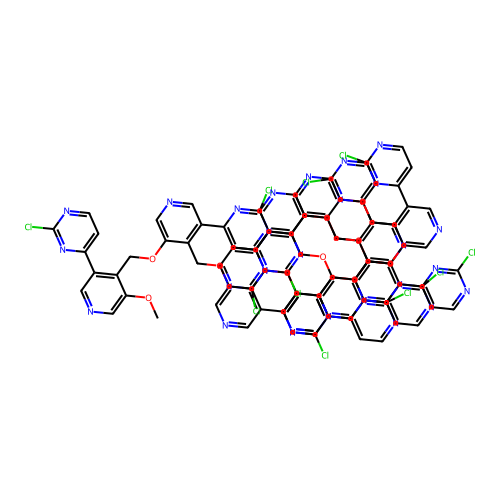

In [15]:
%%time

##plot a single example
img = plot_single_mol(list(set(valid_smiles))[1])
img.save(WRITEPATH + '/GAN_generated_img.png')
img

CPU times: user 3.44 s, sys: 10.1 ms, total: 3.45 s
Wall time: 3.44 s


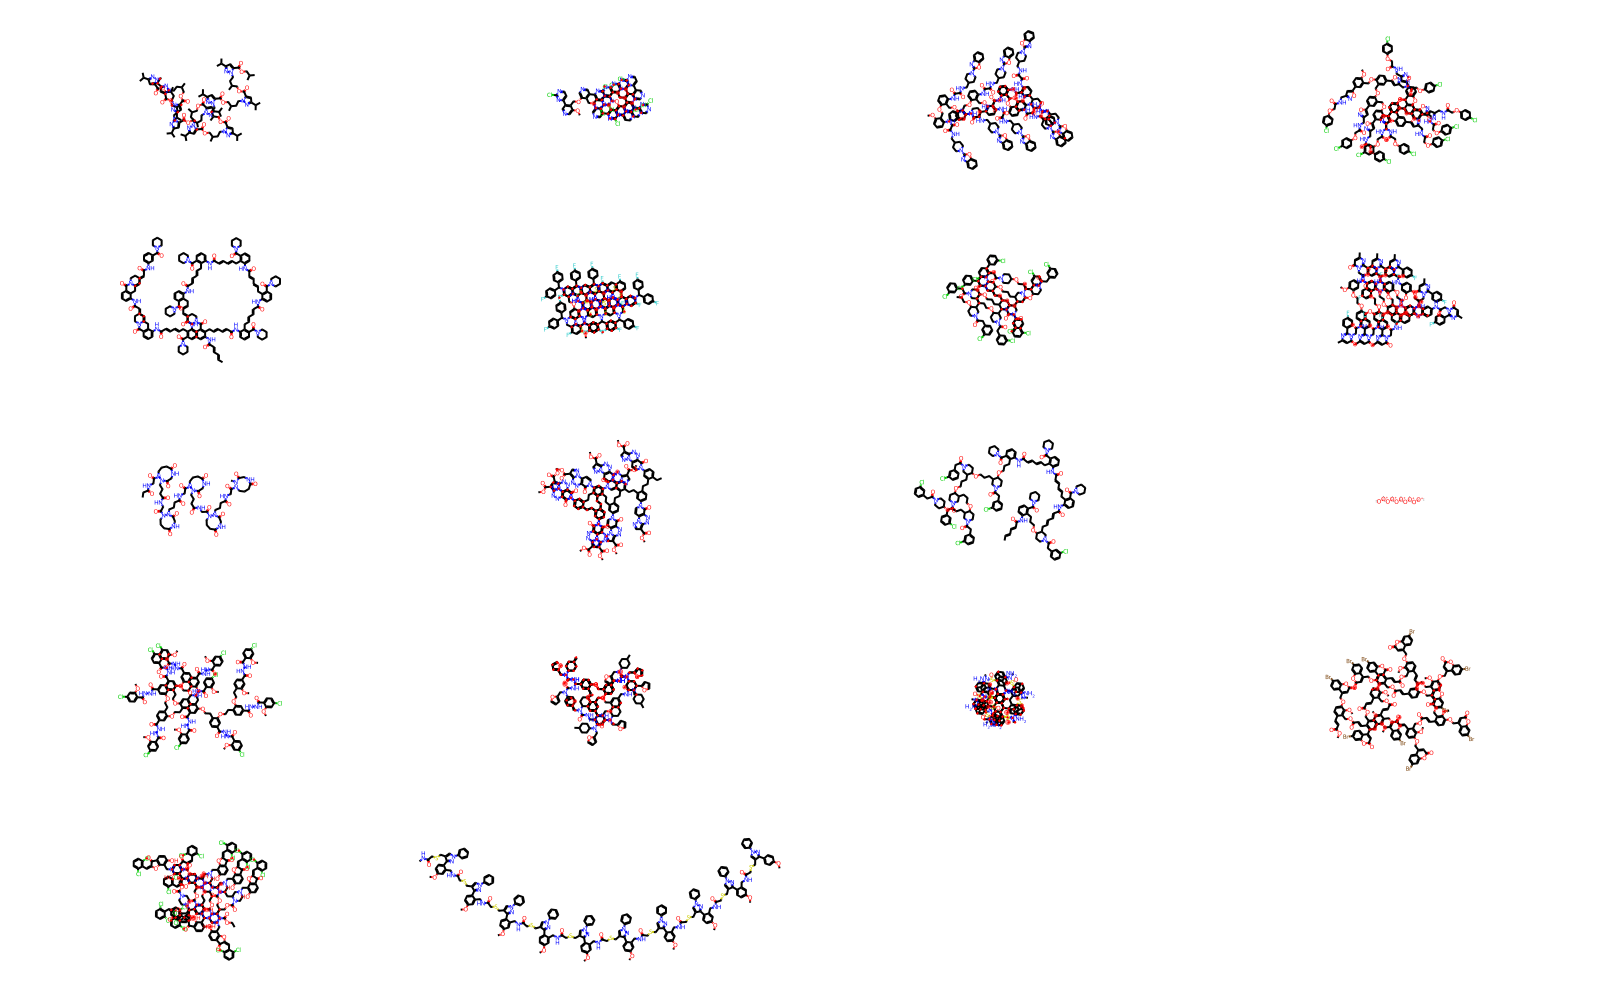

In [16]:
%%time

grid_img = plot_smiles_grid(smiles_list=list(set(valid_smiles)))
with open(WRITEPATH + "/grid_gan_generated.png", "wb") as f:
    f.write(grid_img.data)

grid_img

In [17]:
##clean and time
gc.collect()
torch.cuda.empty_cache()
tf = time.time()
print('Total Runtime: ', np.round(tf - t0, 3))

Total Runtime:  111.258


### REFERENCES

Alqahtani, H. E. (2019, Dec 19). Applications of Generative Adversarial Networks (GANS): An Updated Review.

Arjovsky, M. E. (2017, Jan 26). Wasserstein GAN.

Bidisha, S. (2019). NeVAE: A Deep Generative Model for Molecular Graphs.

Goodfellow, E. A. (2014, June 10). Generative Adversarial Networks.

Jaun-Ni Wu, E. A. (2024). t-SMILES: A Fragment-based Molecular Representation Framework for De Novo Ligand Design. Hunan, China.

National Library of Medicine. (2024, July 22). National Center for Biotechnology Information. Retrieved from PubChem: https://pubchem.ncbi.nlm.nih.gov/

Nicola De Cao, T. K. (2018). MolGAN: An Implicit Generative Model for Small Molecular Graphs. Stochholm, Sweden.